# Hybrid assemblies analysis

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date
today = date.today()

print(f'Aniket Mane & Cedric Chauve\n{today}')

Aniket Mane & Cedric Chauve
2022-10-10


## Overview

This document contains a very preliminary analysis of the the *Enterococcus* data sets. 
It focuses on two questions:
- accuracy of using the hybrid assemblies to define ground truth plasmids;
- performances of plasmid prediction methods on the data sets.

The main outcome of the first part of the analysis is that the hybrid assembliers do not provide an accurate source for esablishing plasmids ground truth, thus rending the second part much less informative.

In [2]:
#!pip install matplotlib

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Datasets statistics files
Efaecalis_isolates = 'isolate_details_Efaecalis.csv'
Efaecium_isolates = 'isolate_details_Efaecium.csv'
Efaecalis_contigs = 'ctg_details_Efaecalis.csv'
Efaecium_contigs = 'ctg_details_Efaecium.csv'

## Data

The statistics about hybrid assemblies are available in the files `ctg_details_Efaecalis.csv` and `ctg_details_Efaecium.csv`.

The results of **HyAsP**, **MOBSuite** and **PlasBin** are available in the files `isolate_details_Efaecalis.csv` and `isolate_details_Efaecium.csv`.

## Labelling hybrid contigs

The goal of labelling hybrid contigs is to identify which such contigs are likely plasmid contigs, in order they can be used to define the ground truth for the short-reads assemblies, through mapping short-reads contigs onto hybrid contigs.

For each species, we determine, from the length distribution of the circular hybrid contigs for all isolates, a **threshold L** that separates short circular contigs (plasmids) from other contigs (chromosomes).

Then we assign a class to each hybrid contig as follows:
- circular contigs of length at most **L** are labelled as *plasmids*;
- contigs (circular or otherwise) that are longer than **L** are labelled as *chromosomes*;
- all remaining contigs are labelled as *ambiguous*.


## E. faecalis

We present our analysis of the *E. faecalis* isolates.
In the following, contig refer to hybrid contigs.

##### Statistics on isolates and contigs

In [4]:
# Reading hybrid contigs details.
EFAECALIS_CONTIGS = pd.read_csv('ctg_details_Efaecalis.csv')
EFAECALIS_CONTIGS_NB = len(EFAECALIS_CONTIGS)
EFAECALIS_NB_SAMPLES = len(EFAECALIS_CONTIGS['SRA'].value_counts())
# Plasmid contigs
EFAECALIS_PLASMIDS = EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS['classification'] == 'plasmid')]
EFAECALIS_NB_PLASMIDS = EFAECALIS_PLASMIDS.shape[0]
EFAECALIS_NB_PLASMIDS_SAMPLES = len(EFAECALIS_PLASMIDS['SRA'].value_counts())

In [5]:
print(f'The total number of E. faecalis isolates is {EFAECALIS_NB_SAMPLES} and of contigs over all isolates is {EFAECALIS_CONTIGS_NB}')
print(f'The number of contigs labelled as plasmid over all isolates is {EFAECALIS_NB_PLASMIDS}')
print(f'The number of samples with no contig labelled as plasmid is {EFAECALIS_NB_SAMPLES-EFAECALIS_NB_PLASMIDS_SAMPLES}')

The total number of E. faecalis isolates is 60 and of contigs over all isolates is 958
The number of contigs labelled as plasmid over all isolates is 73
The number of samples with no contig labelled as plasmid is 18


##### Length distribution of circular contigs

The key parameter to labelling contigs as is the threshold **L**, that has to be chosen in an informed way. Our approach is to consider only circular contigs and to select a threshold that separates long circular contigs (likely from chromosomes) from smaller ones (likely plasmids).

In [6]:
CIRCULAR_CONTIGS = EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS['circularity'] == 1)]
CIRCULAR_CONTIGS_CHROM = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'chromosome']
CIRCULAR_CONTIGS_PLASMIDS = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'plasmid']

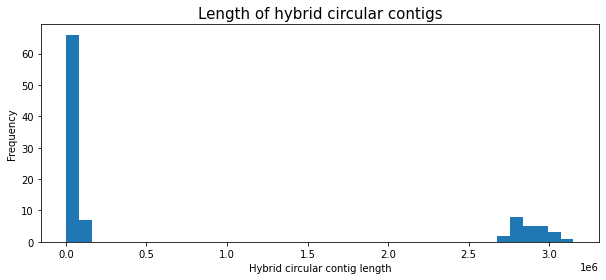

In [7]:
figure1 = CIRCULAR_CONTIGS.hist(column=["contig_length"], bins=40, figsize=(10,4))
plt.title('Length of hybrid circular contigs', fontsize=15)
plt.xlabel('Hybrid circular contig length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The figure above shows a very clear separation between short and long circular contigs, however leaving a very large gap where to chose **L**. We take a stringent approach and choose a small value of **L = 300000**.

In [8]:
EFAECALIS_THRESHOLD = 300000

In [9]:
print(f'Over all E. faecalis isolates there are {len(CIRCULAR_CONTIGS)} circular contigs')
print(f'  {len(CIRCULAR_CONTIGS_CHROM)} are classified as chromosome')
print(f'  {len(CIRCULAR_CONTIGS_PLASMIDS)} are classified as plasmid')

Over all E. faecalis isolates there are 97 circular contigs
  24 are classified as chromosome
  73 are classified as plasmid


The small number of chromosome contigs compared to the total number of isolates shows that on average the chromosome is not fully assembled, and that our labelling method will not label many chromosomal contigs. 

##### Hybrid contigs classified as plasmids

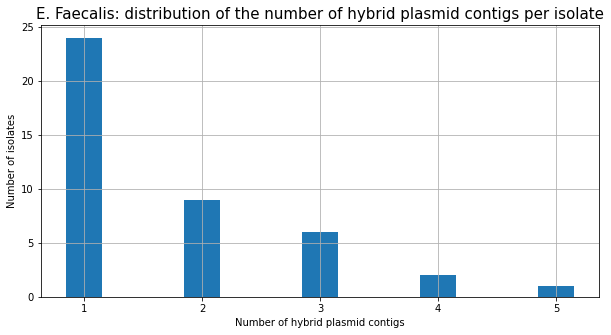

In [11]:
# Number of hybrid plasmid ontigs per isolate with at least one
EFAECALIS_PLASMIDS_CTGS_labels, EFAECALIS_PLASMIDS_CTGS_counts = np.unique(EFAECALIS_PLASMIDS['SRA'].value_counts(), return_counts=True)
figure2 = plt.figure(figsize=(10,5))
plt.title('E. Faecalis: distribution of the number of hybrid plasmid contigs per isolate', fontsize=15)
plt.xlabel('Number of hybrid plasmid contigs')
plt.ylabel('Number of isolates')
plt.bar(EFAECALIS_PLASMIDS_CTGS_labels, EFAECALIS_PLASMIDS_CTGS_counts, align='center', width=0.3)
plt.grid()
plt.gca().set_xticks(EFAECALIS_PLASMIDS_CTGS_labels)
plt.show()

The above figure seems reasonable. We do not see isolates with an unexpectedly large number of plasmids (reminder that as we impose circularity to contigs labelled plasmids, we expect each such contig to be a fully assmebled plasmid).

##### Distribution of contig lengths per label

We now look at the three classes of contigs (plasmid, chromsome and ambiguous), especially to understand better features of ambiguous contigs, whose large number casts a shadow on the whole project.

In [12]:
#Re-assigning labels to non-circular contigs smaller than the threshold as 'ambiguous'
for i, row in EFAECALIS_CONTIGS.iterrows():
    if (EFAECALIS_CONTIGS.loc[i,'classification'] == 'chromosome') & (EFAECALIS_CONTIGS.loc[i,'contig_length'] <= EFAECALIS_THRESHOLD):
        EFAECALIS_CONTIGS.at[i,'classification'] = 'ambiguous'     

In [13]:
EFAECALIS_PLASMID_NB = EFAECALIS_CONTIGS[EFAECALIS_CONTIGS['classification'] == 'chromosome'].shape[0]
EFAECALIS_CHROM_NB = EFAECALIS_CONTIGS[EFAECALIS_CONTIGS['classification'] == 'plasmid'].shape[0]
EFAECALIS_AMBIG_NB = EFAECALIS_CONTIGS[EFAECALIS_CONTIGS['classification'] == 'ambiguous'].shape[0]
print(f'Number of chromosome contigs: {EFAECALIS_CHROM_NB}')
print(f'Number of plasmid contigs: {EFAECALIS_PLASMID_NB}')
print(f'Number of ambiguous contigs: {EFAECALIS_AMBIG_NB}')

Number of chromosome contigs: 73
Number of plasmid contigs: 71
Number of ambiguous contigs: 814


Overall we see that a very large number of contigs are ambiguous. We will discuss this later. But first we look at the length distribution of the contigs per class.

Hybrid contig length distribution per class


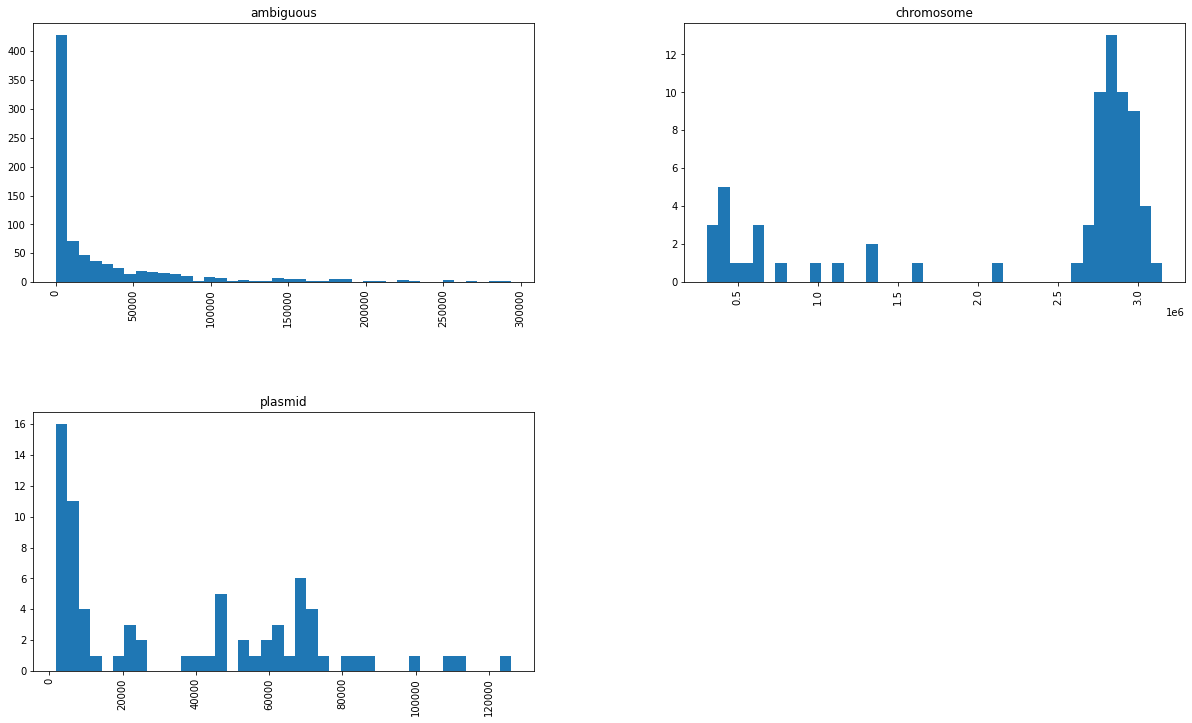

In [14]:
EFAECALIS_CONTIGS_LEN = EFAECALIS_CONTIGS[['contig_length','classification']]
print(f'Hybrid contig length distribution per class')
figure4 = EFAECALIS_CONTIGS_LEN.hist(by="classification", bins=40, figsize=(20, 12))

In [15]:
nb_short_contigs = len(EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS["contig_length"] <= EFAECALIS_THRESHOLD)])
nb_short_ambig_contigs = len(EFAECALIS_CONTIGS[(EFAECALIS_CONTIGS["contig_length"] <= EFAECALIS_THRESHOLD) & (EFAECALIS_CONTIGS['classification'] == 'ambiguous')])
print(f'{nb_short_contigs} out of {EFAECALIS_CONTIGS_NB} contigs are under {EFAECALIS_THRESHOLD} bp in length and {nb_short_ambig_contigs} of these contigs have been classified as ambiguous.')

887 out of 958 contigs are under 300000 bp in length and 814 of these contigs have been classified as ambiguous.


Most of the ambiguous contigs are very short. There is a strong separation between plasmid and chromosome contigs, with the chosen threshold (300000bp) to label contigs as plasmid being far from the largest plasmid contig. 

The separation beween ambiguous and chromosome contigs is much less clear, although the number of long ambiguous contigs is quite small. 

The main question is about the large number of relatively short ambiguous contigs: how many true plasmid contigs do-we miss?

In terms of subsequent analysis, the impact of ambiguous contigs is also crucial: how should we handle such contigs if a plasmid prediction tool includes some in predicted plasmids.

In [89]:
def split_by_threshold(L, df):
    PLS_NB = df[(df['contig_length'] <= L) & (df['circularity'] == 1)].shape[0]
    CHR_NB = df[df['contig_length'] > L].shape[0]
    AMB_NB = df.shape[0] - PLS_NB - CHR_NB
    return CHR_NB, PLS_NB, AMB_NB

M = 100000
R = 20
print(f'Length thresholds from {M} to {R*M} (bp) in multiples of {M}')
THRESHOLDS = np.array([i*100000 for i in range(1,21)])

Length thresholds from 100000 to 2000000 (bp) in multiples of 100000


Length thresholds from 100000 to 2000000 (bp) in multiples of 100000


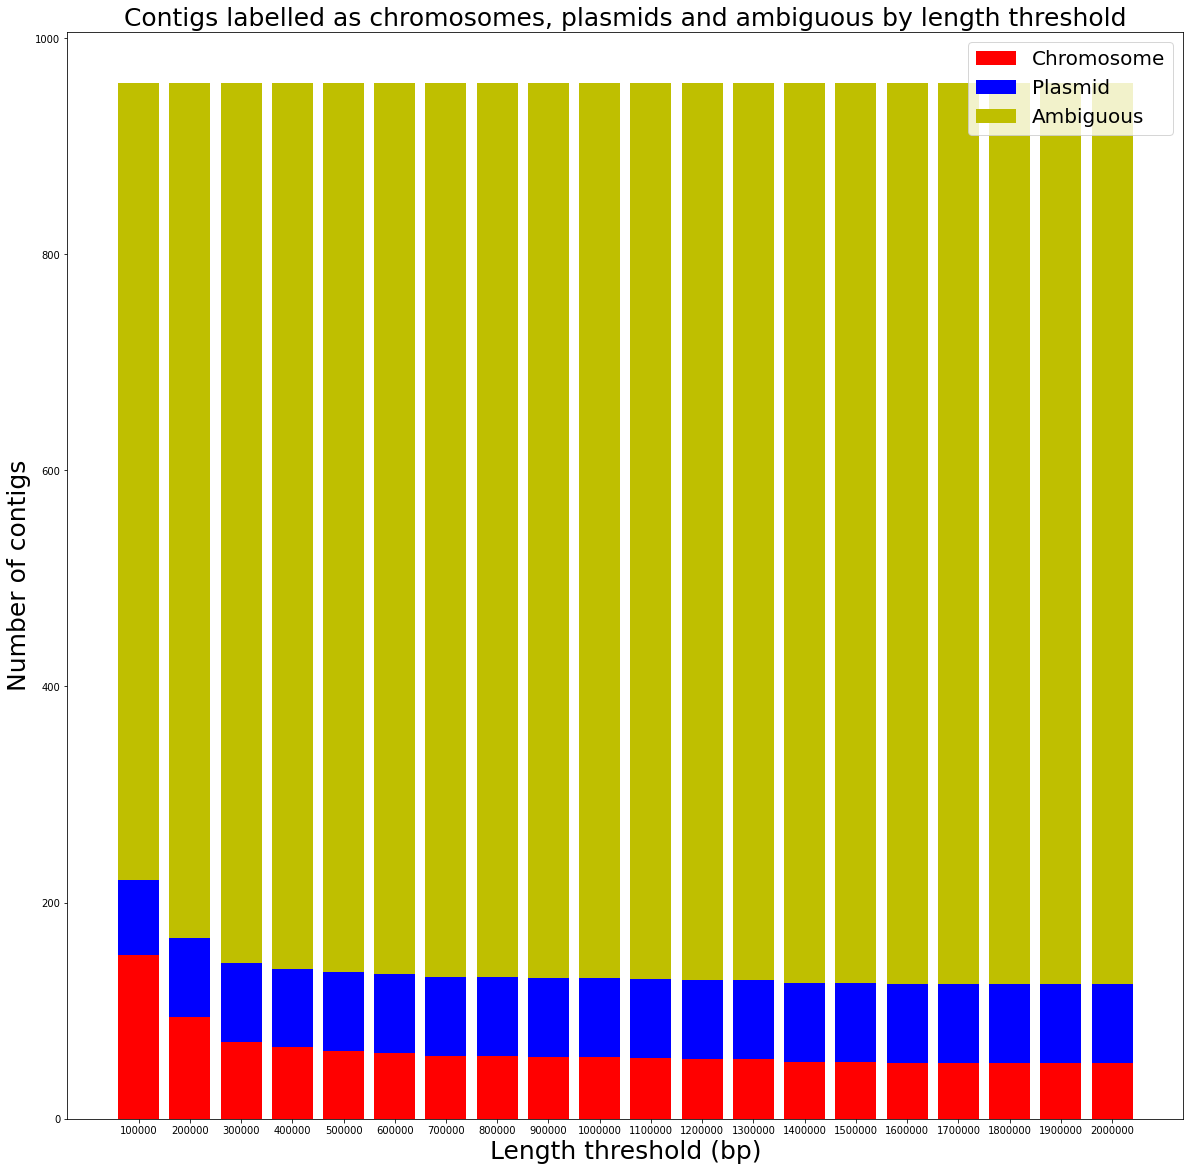

In [75]:
EFAECALIS_CHR_BY_THRESHOLD, EFAECALIS_PLS_BY_THRESHOLD, EFAECALIS_AMB_BY_THRESHOLD = np.empty(20),np.empty(20),np.empty(20) 

for i in range(len(THRESHOLDS)):
    L = THRESHOLDS[i]
    CHR_NB, PLS_NB, AMB_NB = split_by_threshold(L, EFAECALIS_CONTIGS)
    EFAECALIS_CHR_BY_THRESHOLD[i] = CHR_NB 
    EFAECALIS_PLS_BY_THRESHOLD[i] = PLS_NB
    EFAECALIS_AMB_BY_THRESHOLD[i] = AMB_NB
THR_LIST = [str(x) for x in THRESHOLDS]

figure3 = plt.figure(figsize=(20,20))
plt.bar(THR_LIST, EFAECALIS_CHR_BY_THRESHOLD, color='r')
plt.bar(THR_LIST, EFAECALIS_PLS_BY_THRESHOLD, bottom=EFAECALIS_CHR_BY_THRESHOLD, color='b')
plt.bar(THR_LIST, EFAECALIS_AMB_BY_THRESHOLD, bottom=EFAECALIS_CHR_BY_THRESHOLD+EFAECALIS_PLS_BY_THRESHOLD, color='y')

plt.xlabel("Length threshold (bp)",fontsize=25)
plt.ylabel("Number of contigs",fontsize=25)
plt.legend(["Chromosome", "Plasmid", "Ambiguous"],fontsize=20)
plt.title("Contigs labelled as chromosomes, plasmids and ambiguous by length threshold",fontsize=25)
plt.show()

### E. faecium

We present our analysis of the *E. faecium* isolates. (Contig refer to hybrid contigs.)

##### Statistics on isolates and contigs

In [77]:
# Reading hybrid contigs details.
EFAECIUM_CONTIGS = pd.read_csv('ctg_details_Efaecium.csv')
EFAECIUM_CONTIGS_NB = len(EFAECIUM_CONTIGS)
EFAECIUM_NB_SAMPLES = len(EFAECIUM_CONTIGS['SRA'].value_counts())
# Plasmid contigs
EFAECIUM_PLASMIDS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['classification'] == 'plasmid')]
EFAECIUM_NB_PLASMIDS = EFAECIUM_PLASMIDS.shape[0]
EFAECIUM_NB_PLASMIDS_SAMPLES = len(EFAECIUM_PLASMIDS['SRA'].value_counts())

In [79]:
print(f'The total number of E. faecium isolates is {EFAECIUM_NB_SAMPLES} and of contigs over all isolates is {EFAECIUM_CONTIGS_NB}')
print(f'The number of contigs labelled as plasmid over all isolates is {EFAECIUM_NB_PLASMIDS}')
print(f'The number of samples with no contig labelled as plasmid is {EFAECIUM_NB_SAMPLES-EFAECIUM_NB_PLASMIDS_SAMPLES}')

The total number of E. faecium isolates is 71 and of contigs over all isolates is 3538
The number of contigs labelled as plasmid over all isolates is 174
The number of samples with no contig labelled as plasmid is 12


##### Length distribution of circular contigs

In [80]:
CIRCULAR_CONTIGS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['circularity'] == 1)]
CIRCULAR_CONTIGS_CHROM = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'chromosome']
CIRCULAR_CONTIGS_PLASMIDS = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'plasmid']

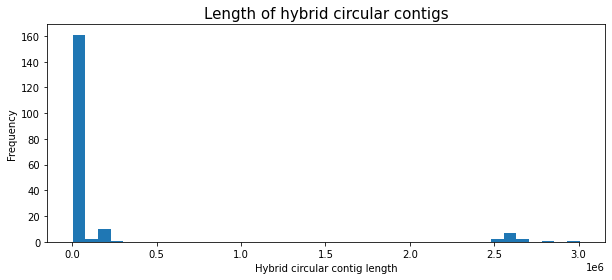

In [81]:
figure5 = CIRCULAR_CONTIGS.hist(column=["contig_length"], bins=40, figsize=(10,4))
plt.title('Length of hybrid circular contigs', fontsize=15)
plt.xlabel('Hybrid circular contig length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

As with E. faecalis, the choice for L is left unclear. We choose a small value of L = 300000.

In [82]:
EFAECIUM_THRESHOLD = 300000

In [83]:
print(f'Over all E. faecium isolates there are {len(CIRCULAR_CONTIGS)} circular contigs')
print(f'  {len(CIRCULAR_CONTIGS_CHROM)} are classified as chromosome')
print(f'  {len(CIRCULAR_CONTIGS_PLASMIDS)} are classified as plasmid')

Over all E. faecium isolates there are 187 circular contigs
  13 are classified as chromosome
  174 are classified as plasmid


E. faecium shows the same trend as E. faecalis. The number of chromosome contigs is very small compared to the total number of isolates indicating that not all chromosomes are not fully assembled. 

##### Hybrid contigs classified as plasmids

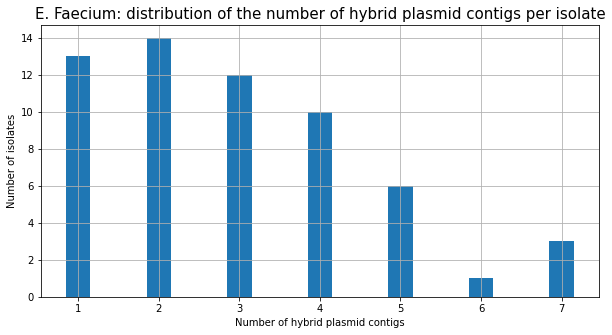

In [84]:
# Number of hybrid plasmid ontigs per isolate with at least one
EFAECIUM_PLASMIDS_CTGS_labels, EFAECIUM_PLASMIDS_CTGS_counts = np.unique(EFAECIUM_PLASMIDS['SRA'].value_counts(), return_counts=True)
figure6 = plt.figure(figsize=(10,5))
plt.title('E. Faecium: distribution of the number of hybrid plasmid contigs per isolate', fontsize=15)
plt.xlabel('Number of hybrid plasmid contigs')
plt.ylabel('Number of isolates')
plt.bar(EFAECIUM_PLASMIDS_CTGS_labels, EFAECIUM_PLASMIDS_CTGS_counts, align='center', width=0.3)
plt.grid()
plt.gca().set_xticks(EFAECIUM_PLASMIDS_CTGS_labels)
plt.show()

##### Distribution of contig lengths per label

We now look at the three classes of contigs (plasmid, chromsome and ambiguous) for E. faecium isolates.

In [85]:
#Re-assigning labels to non-circular contigs smaller than the threshold as 'ambiguous'
for i, row in EFAECIUM_CONTIGS.iterrows():
    if (EFAECIUM_CONTIGS.loc[i,'classification'] == 'chromosome') & (EFAECIUM_CONTIGS.loc[i,'contig_length'] <= 300000):
        EFAECIUM_CONTIGS.at[i,'classification'] = 'ambiguous'

In [86]:
EFAECIUM_PLASMID_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'chromosome'].shape[0]
EFAECIUM_CHROM_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'plasmid'].shape[0]
EFAECIUM_AMBIG_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'ambiguous'].shape[0]
print(f'Number of chromosome contigs: {EFAECIUM_CHROM_NB}')
print(f'Number of plasmid contigs: {EFAECIUM_PLASMID_NB}')
print(f'Number of ambiguous contigs: {EFAECIUM_AMBIG_NB}')

Number of chromosome contigs: 174
Number of plasmid contigs: 114
Number of ambiguous contigs: 3250


Hybrid contig length distribution per class


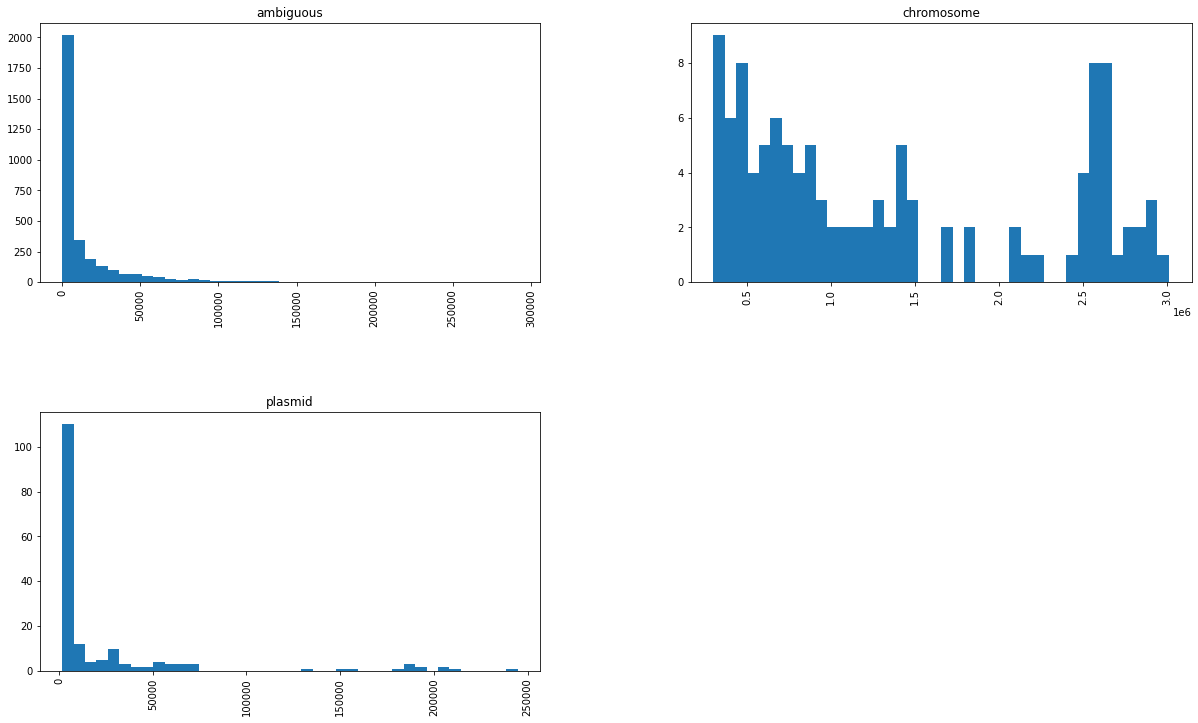

In [87]:
EFAECIUM_CONTIGS_LEN = EFAECIUM_CONTIGS[['contig_length','classification']]
print(f'Hybrid contig length distribution per class')
figure7 = EFAECIUM_CONTIGS_LEN.hist(by="classification", bins=40, figsize=(20, 12))

In [88]:
nb_short_contigs = len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= EFAECIUM_THRESHOLD)])
nb_short_ambig_contigs = len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= EFAECIUM_THRESHOLD) & (EFAECIUM_CONTIGS['classification'] == 'ambiguous')])
print(f'{nb_short_contigs} out of {EFAECIUM_CONTIGS_NB} contigs are under {EFAECIUM_THRESHOLD} bp in length and {nb_short_ambig_contigs} of these contigs have been classified as ambiguous.')

3424 out of 3538 contigs are under 300000 bp in length and 3250 of these contigs have been classified as ambiguous.


All of the ambiguous and plasmid contigs are shorter than 150000 bp. This indicates a strong separation between ambiguous/plasmid and chromosome contigs, with the chosen threshold (300000bp). However, it is unclear if ambiguous contigs are  fragments of chromosomes or should be considered independent plasmids.

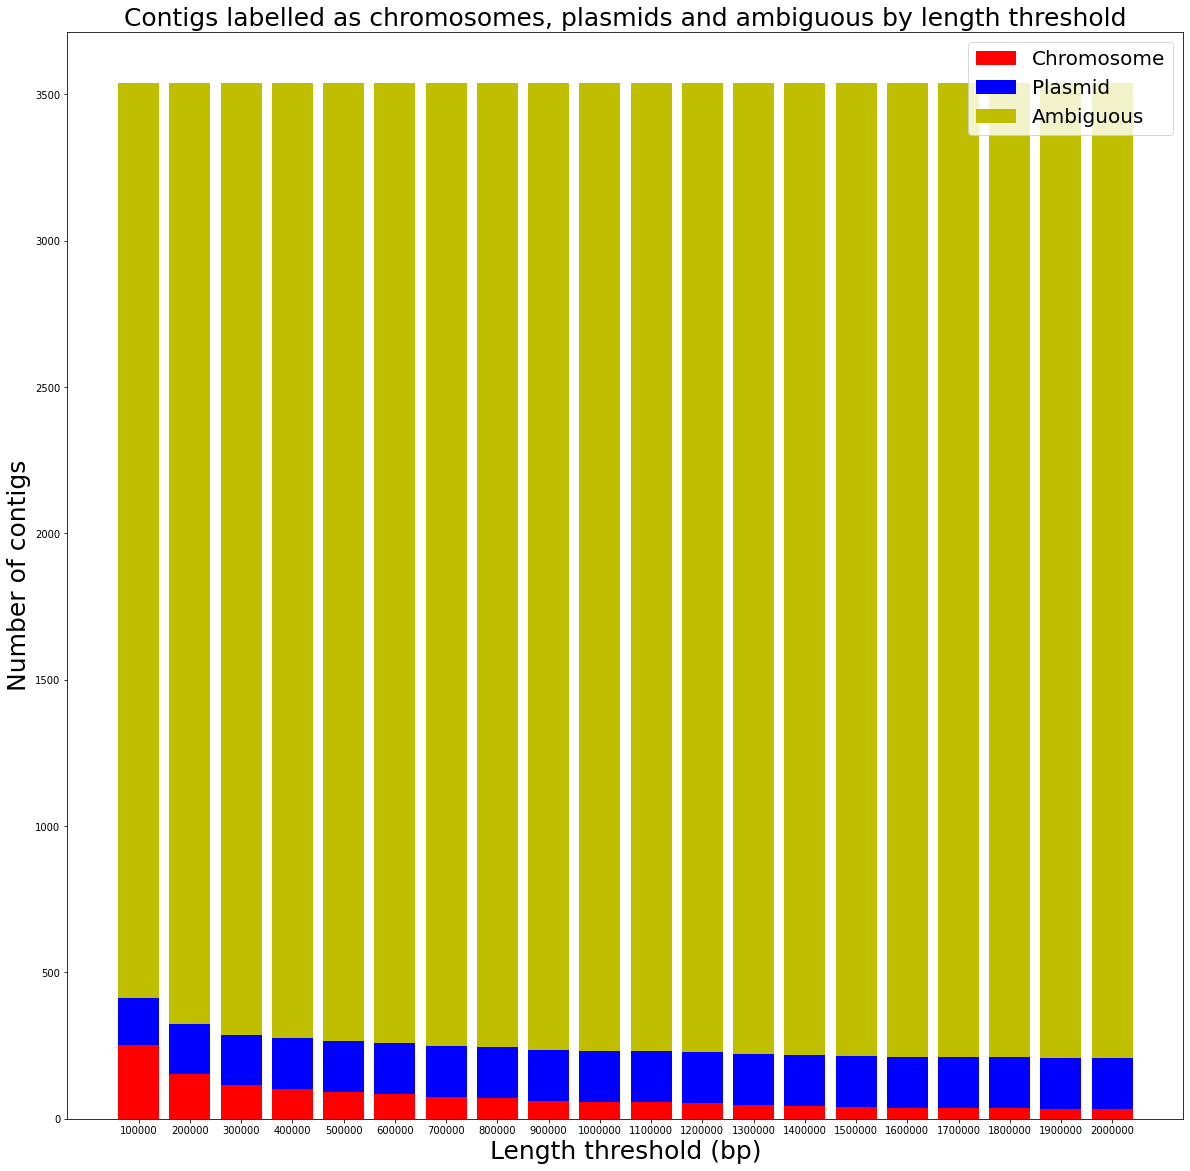

In [90]:
EFAECIUM_CHR_BY_THRESHOLD, EFAECIUM_PLS_BY_THRESHOLD, EFAECIUM_AMB_BY_THRESHOLD = np.empty(20),np.empty(20),np.empty(20) 

for i in range(len(THRESHOLDS)):
    L = THRESHOLDS[i]
    CHR_NB, PLS_NB, AMB_NB = split_by_threshold(L, EFAECIUM_CONTIGS)
    EFAECIUM_CHR_BY_THRESHOLD[i] = CHR_NB 
    EFAECIUM_PLS_BY_THRESHOLD[i] = PLS_NB
    EFAECIUM_AMB_BY_THRESHOLD[i] = AMB_NB
THR_LIST = [str(x) for x in THRESHOLDS]

figure3 = plt.figure(figsize=(20,20))
plt.bar(THR_LIST, EFAECIUM_CHR_BY_THRESHOLD, color='r')
plt.bar(THR_LIST, EFAECIUM_PLS_BY_THRESHOLD, bottom=EFAECIUM_CHR_BY_THRESHOLD, color='b')
plt.bar(THR_LIST, EFAECIUM_AMB_BY_THRESHOLD, bottom=EFAECIUM_CHR_BY_THRESHOLD+EFAECIUM_PLS_BY_THRESHOLD, color='y')

plt.xlabel("Length threshold (bp)",fontsize=25)
plt.ylabel("Number of contigs",fontsize=25)
plt.legend(["Chromosome", "Plasmid", "Ambiguous"],fontsize=20)
plt.title("Contigs labelled as chromosomes, plasmids and ambiguous by length threshold",fontsize=25)
plt.show()

### Comparison against ground truth

We used PlasBin, HyAsP, MOB-recon and plasmidSPAdes to predict plasmids using the short read contigs and assembly graphs. Thus, we obtained plasmids as bins of short read contigs. We use hybrid contigs classified as plasmids to represent the ground truth plasmids. In order to compare the predictions against the ground truth, we obtain short read contig set representations of the hybrid contigs. We do so by mapping the short read contigs onto the hybrid contigs using minimap2. The hybrid contig mappings have been stored in the "data/Hybrid_Contigs_Plasmids". For each isolate, we then compare the predictions against the ground truth plasmid bins using PlasEval. We obtain a score that measures the dissimilarity between the ground truth and the predicted plasmid bins.

In [91]:
EFAECALIS_ISOLATES = pd.read_csv('isolate_details_Efaecalis.csv')
EFAECIUM_ISOLATES = pd.read_csv('isolate_details_Efaecium.csv')

#### E. faecalis

In [92]:
#EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'][~EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

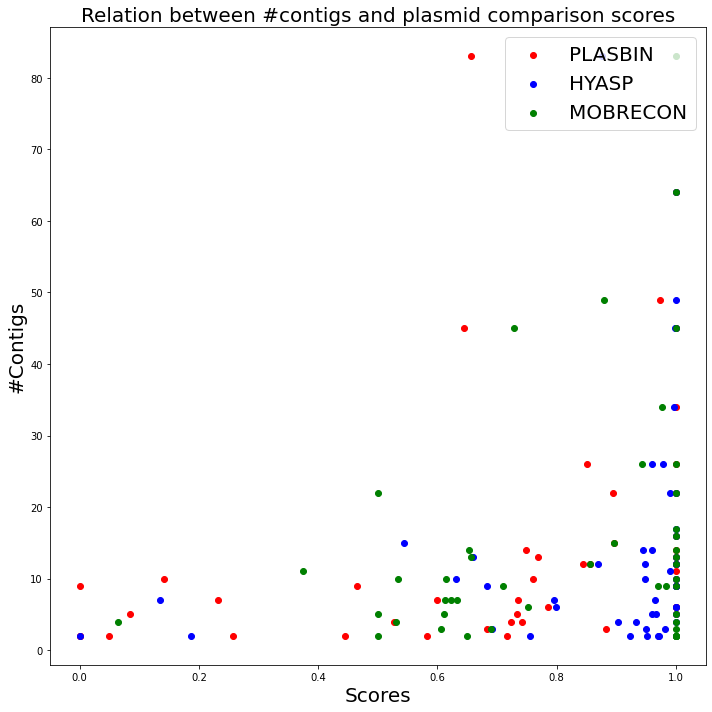

In [96]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECALIS_ISOLATES['pb'],y=EFAECALIS_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECALIS_ISOLATES['hy'],y=EFAECALIS_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECALIS_ISOLATES['mob'],y=EFAECALIS_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. This suggests that the ground truth is dissimilar to the predicted plasmid bins. Furthermore, if the isolate contains more than 20 hybrid contigs, the dissimilarity score is almost always above 0.5. There is no clear indication as to which tool performs better in terms of similarity to the ground truth.

#### E. faecium

In [94]:
#EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'][~EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

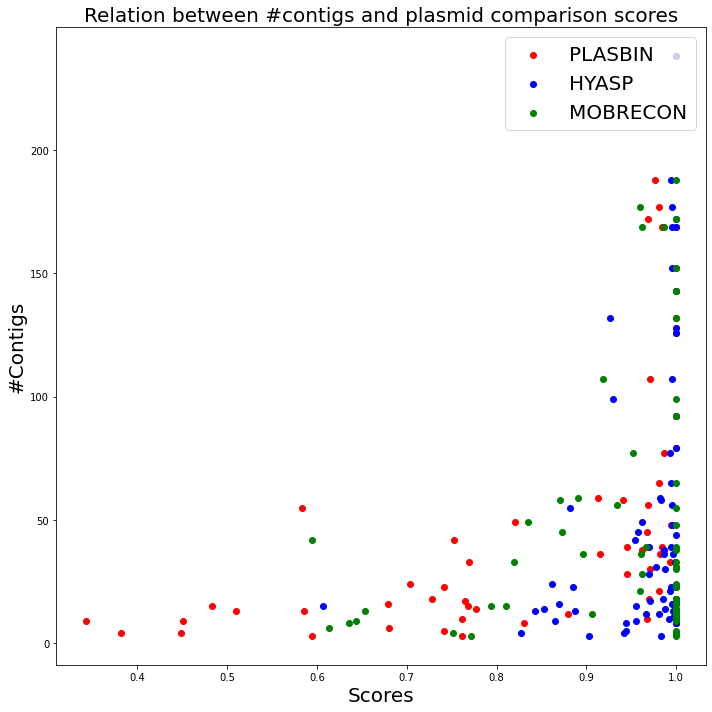

In [95]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECIUM_ISOLATES['pb'],y=EFAECIUM_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECIUM_ISOLATES['hy'],y=EFAECIUM_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECIUM_ISOLATES['mob'],y=EFAECIUM_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. In fact, all tools consistently have predictions that have a dissimilarity score >= 0.5, with the exception of PlasBin. For isolates having more than 50 contigs, the dissimilarity score is almost always greater than 0.6. 

The high level of dissimilarity from all the tools can be explained by the lack of representation of plasmidic hybrid contigs in the dataset. It is likely that the plasmids have been fragemented into smaller linear contigs. As a result, these contigs are misclassified. This can be especially observed in isolates with high number of contigs.